In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
import os

In [30]:
print(os.getcwd())

/content


In [31]:
data_path = "/content/drive/MyDrive/NER_Data_prep/Dataset/medical_domain_ner_dataset"

# Tokenization

In [32]:
%%capture
!pip install datasets
!pip install evaluate
!pip install seqeval
!pip install accelerate -U
!pip install git+https://github.com/huggingface/transformers.git@6e0515e99c39444caae39472ee1b2fd76ece32f1
!pip install torch

In [33]:
import os
from transformers import BertTokenizerFast
from datasets import load_dataset,load_from_disk

In [34]:
ner_dataset = load_from_disk(data_path)
print(ner_dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'tokens', 'ner_tags'],
        num_rows: 388
    })
    validation: Dataset({
        features: ['text', 'tokens', 'ner_tags'],
        num_rows: 49
    })
    test: Dataset({
        features: ['text', 'tokens', 'ner_tags'],
        num_rows: 49
    })
})


In [35]:
ner_dataset["train"].features["ner_tags"]

Sequence(feature=ClassLabel(names=['O', 'B-CONDITION', 'I-CONDITION', 'B-MEDICATION', 'I-MEDICATION', 'B-PROCEDURE', 'I-PROCEDURE', 'B-SYMPTOM', 'I-SYMPTOM', 'B-TEST', 'I-TEST', 'B-DOSAGE', 'B-ALLERGEN', 'I-ALLERGEN'], id=None), length=-1, id=None)

In [36]:
print(ner_dataset['train'].description)


NER Tag Definitions:
{
    "B-CONDITION": "Medical condition (e.g., Diabetes, हृदय रोग, Asthma, TB)",
    "I-CONDITION": "Continuation of condition",
    "B-MEDICATION": "Medicines (e.g., Insulin, Paracetamol, Dolo-650)",
    "I-MEDICATION": "Continuation of medication",
    "B-PROCEDURE": "Medical procedure (e.g., Angioplasty, X-ray, डायलिसिस)",
    "I-PROCEDURE": "Continuation of procedure",
    "B-SYMPTOM": "Symptoms (e.g., बुखार, Chest pain, Fatigue)",
    "I-SYMPTOM": "Continuation of symptom",
    "B-TEST": "Lab/diagnostic test (e.g., ECG, Lipid Profile, ब्लड टेस्ट)",
    "I-TEST": "Continuation of test",
    "B-DOSAGE": "Dosage/measurement (e.g., 5mg, 200mL, twice daily)",
    "B-ALLERGEN": "Allergens (e.g., Penicillin, धूल, Peanuts)",
    "I-ALLERGEN": "Continuation of allergen",
    "O": "Non-entity tokens"
}



In [37]:
FINETUNED_MODEL_ID = "answerdotai/ModernBERT-large"
OUTPUT_DATASET_PATH = "/content/drive/MyDrive/NER_Data_prep/Dataset/tokenized_dataset"

In [38]:
tokenizer = BertTokenizerFast.from_pretrained(FINETUNED_MODEL_ID)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'PreTrainedTokenizerFast'. 
The class this function is called from is 'BertTokenizerFast'.


In [39]:
def tokenize_and_align_labels(examples, label_all_tokens=True):
    """
    Function to tokenize and align labels with respect to the tokens. This function is specifically designed for
    Named Entity Recognition (NER) tasks where alignment of the labels is necessary after tokenization.

    Parameters:
    examples (dict): A dictionary containing the tokens and the corresponding NER tags.
                     - "tokens": list of words in a sentence.
                     - "ner_tags": list of corresponding entity tags for each word.

    label_all_tokens (bool): A flag to indicate whether all tokens should have labels.
                             If False, only the first token of a word will have a label,
                             the other tokens (subwords) corresponding to the same word will be assigned -100.

    Returns:
    tokenized_inputs (dict): A dictionary containing the tokenized inputs and the corresponding labels aligned with the tokens.
    """
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)
    labels = []
    for i, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        # word_ids() => Return a list mapping the tokens
        # to their actual word in the initial sentence.
        # It Returns a list indicating the word corresponding to each token.
        previous_word_idx = None
        label_ids = []
        # Special tokens like `<s>` and `<\s>` are originally mapped to None
        # We need to set the label to -100 so they are automatically ignored in the loss function.
        for word_idx in word_ids:
            if word_idx is None:
                # set –100 as the label for these special tokens
                label_ids.append(-100)
            # For the other tokens in a word, we set the label to either the current label or -100, depending on
            # the label_all_tokens flag.
            elif word_idx != previous_word_idx:
                # if current word_idx is != prev then its the most regular case
                # and add the corresponding token
                label_ids.append(label[word_idx])
            else:
                # to take care of sub-words which have the same word_idx
                # set -100 as well for them, but only if label_all_tokens == False
                label_ids.append(label[word_idx] if label_all_tokens else -100)
                # mask the subword representations after the first subword

            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [40]:
q = tokenize_and_align_labels(examples=ner_dataset['train'][40:41])
print(q)

{'input_ids': [[50281, 34, 1449, 14, 2913, 14, 744, 15325, 15068, 264, 3113, 40192, 1962, 296, 31406, 395, 14458, 1255, 1171, 3381, 506, 6050, 251, 66, 31045, 936, 30598, 33358, 46175, 15754, 12001, 2483, 107, 12001, 46175, 2811, 248, 4238, 303, 26639, 1065, 251, 22, 7913, 48, 19, 4032, 1338, 395, 28821, 3252, 4938, 343, 249, 47357, 15, 50282]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], 'labels': [[-100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11, 12, 12, 0, 0, 0, 0, 0, 3, 3, 3, 0, 0, -100]]}


In [41]:
for token, label in zip(tokenizer.convert_ids_to_tokens(q["input_ids"][0]),q["labels"][0]):
    print(f"{token:_<40} {label}")

[CLS]___________________________________ -100
A_______________________________________ 0
40______________________________________ 0
-_______________________________________ 0
year____________________________________ 0
-_______________________________________ 0
old_____________________________________ 0
patient_________________________________ 0
present_________________________________ 0
ed______________________________________ 0
with____________________________________ 0
severe__________________________________ 0
che_____________________________________ 0
st______________________________________ 0
pain____________________________________ 8
and_____________________________________ 0
short___________________________________ 0
ness____________________________________ 0
of______________________________________ 0
bre_____________________________________ 8
ath_____________________________________ 8
while___________________________________ 0
on______________________________________ 0
a_______

In [57]:
tokenized_datasets = ner_dataset.map(tokenize_and_align_labels, batched=True)

Map:   0%|          | 0/388 [00:00<?, ? examples/s]

Map:   0%|          | 0/49 [00:00<?, ? examples/s]

Map:   0%|          | 0/49 [00:00<?, ? examples/s]

In [58]:
ner_dataset.shape,tokenized_datasets.shape

({'train': (388, 3), 'validation': (49, 3), 'test': (49, 3)},
 {'train': (388, 6), 'validation': (49, 6), 'test': (49, 6)})

In [59]:
tokenized_datasets['test'],ner_dataset['test']

(Dataset({
     features: ['text', 'tokens', 'ner_tags', 'input_ids', 'attention_mask', 'labels'],
     num_rows: 49
 }),
 Dataset({
     features: ['text', 'tokens', 'ner_tags'],
     num_rows: 49
 }))

In [60]:
tokenized_datasets.save_to_disk(OUTPUT_DATASET_PATH)

Saving the dataset (0/1 shards):   0%|          | 0/388 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/49 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/49 [00:00<?, ? examples/s]

# FineTune

In [61]:
import numpy as np
from transformers import AutoTokenizer
from transformers import DataCollatorForTokenClassification
from transformers import AutoModelForTokenClassification
from transformers import TrainingArguments, Trainer
import evaluate
import json
import torch
import pandas as pd


In [62]:
LOGS = "logs"
OUTPUT_DIR = "models"
MODEL_PATH = os.path.join(OUTPUT_DIR, FINETUNED_MODEL_ID)
OUTPUT_MODEL = os.path.join(OUTPUT_DIR, f"medical-ner-{FINETUNED_MODEL_ID.split('/')[-1]}")

EVAL_STRATEGY = "epoch"
LEARNING_RATE = 1e-5
PER_DEVICE_TRAIN_BATCH_SIZE = 10
PER_DEVICE_EVAL_BATCH_SIZE = 10
NUM_TRAIN_EPOCHS = 10
WEIGHT_DECAY = 0.01

In [63]:
tokenized_datasets = load_from_disk(OUTPUT_DATASET_PATH)
print(tokenized_datasets)

DatasetDict({
    train: Dataset({
        features: ['text', 'tokens', 'ner_tags', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 388
    })
    validation: Dataset({
        features: ['text', 'tokens', 'ner_tags', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 49
    })
    test: Dataset({
        features: ['text', 'tokens', 'ner_tags', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 49
    })
})


In [64]:
label_list= tokenized_datasets["train"].features["ner_tags"].feature.names
num_labels = len(label_list)

print(f"Labels: {label_list}")
print(f"Number of labels: {num_labels}")

Labels: ['O', 'B-CONDITION', 'I-CONDITION', 'B-MEDICATION', 'I-MEDICATION', 'B-PROCEDURE', 'I-PROCEDURE', 'B-SYMPTOM', 'I-SYMPTOM', 'B-TEST', 'I-TEST', 'B-DOSAGE', 'B-ALLERGEN', 'I-ALLERGEN']
Number of labels: 14


In [65]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")

Device: cuda


In [66]:
model = AutoModelForTokenClassification.from_pretrained(
    FINETUNED_MODEL_ID, num_labels=num_labels,

    ).to(device)
tokenizer = AutoTokenizer.from_pretrained(FINETUNED_MODEL_ID)

Some weights of ModernBertForTokenClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [67]:
args = TrainingArguments(
    output_dir=MODEL_PATH,
    eval_strategy=EVAL_STRATEGY,
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=PER_DEVICE_TRAIN_BATCH_SIZE,
    per_device_eval_batch_size=PER_DEVICE_EVAL_BATCH_SIZE,
    num_train_epochs=NUM_TRAIN_EPOCHS,
    weight_decay=WEIGHT_DECAY,
)

In [68]:
data_collator = DataCollatorForTokenClassification(tokenizer)

In [69]:
def compute_metrics(eval_preds):
    """
    Function to compute the evaluation metrics for Named Entity Recognition (NER) tasks.
    The function computes precision, recall, F1 score and accuracy.

    Parameters:
    eval_preds (tuple): A tuple containing the predicted logits and the true labels.

    Returns:
    A dictionary containing the precision, recall, F1 score and accuracy.
    """
    pred_logits, labels = eval_preds

    pred_logits = np.argmax(pred_logits, axis=2)
    # the logits and the probabilities are in the same order,
    # so we don’t need to apply the softmax

    # We remove all the values where the label is -100
    predictions = [
        [label_list[eval_preds] for (eval_preds, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(pred_logits, labels)
    ]

    true_labels = [
      [label_list[l] for (eval_preds, l) in zip(prediction, label) if l != -100]
       for prediction, label in zip(pred_logits, labels)
    ]
    metric = evaluate.load("seqeval")
    results = metric.compute(predictions=predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

In [70]:
trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,

)

<ipython-input-70-be6768af147c>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [71]:
trainer.train()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,1.094884,0.490769,0.304099,0.375515,0.668180
2,No log,0.883389,0.593631,0.444233,0.508179,0.734787
3,No log,0.748718,0.573469,0.535748,0.553967,0.764457
4,No log,0.720693,0.674646,0.591039,0.630081,0.805631
5,No log,0.683434,0.697773,0.627264,0.660643,0.821980
6,No log,0.708330,0.704383,0.658723,0.680788,0.829549
7,No log,0.698924,0.796009,0.684461,0.736033,0.854072
8,No log,0.673076,0.780409,0.691134,0.733064,0.858613
9,No log,0.752545,0.778509,0.676835,0.724120,0.851953
10,No log,0.746370,0.784141,0.678742,0.727644,0.854072


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TrainOutput(global_step=390, training_loss=0.37463461068960335, metrics={'train_runtime': 568.4917, 'train_samples_per_second': 6.825, 'train_steps_per_second': 0.686, 'total_flos': 1227721804960008.0, 'train_loss': 0.37463461068960335, 'epoch': 10.0})

In [72]:
os.makedirs(LOGS, exist_ok=True)

In [73]:
results = pd.DataFrame(trainer.state.log_history)
results = results[['epoch', 'eval_precision', 'eval_recall', 'eval_f1', 'eval_accuracy', 'eval_runtime', 'eval_samples_per_second', 'eval_steps_per_second']]
results.dropna(inplace=True)
results.reset_index(drop=True, inplace=True)

# Saving evaluation results in a CSV format for easy visualization and comparison.
model_name = OUTPUT_MODEL.split("/")[-1]
results.to_csv(f"logs/{model_name}-results.csv", index=False)

In [74]:
model.save_pretrained(OUTPUT_MODEL)
tokenizer.save_pretrained(OUTPUT_MODEL)

('models/medical-ner-ModernBERT-large/tokenizer_config.json',
 'models/medical-ner-ModernBERT-large/special_tokens_map.json',
 'models/medical-ner-ModernBERT-large/tokenizer.json')

In [75]:
id2label = {
    str(i): label for i,label in enumerate(label_list)
}
label2id = {
    label: str(i) for i,label in enumerate(label_list)
}

In [76]:
config = json.load(open(f"{OUTPUT_MODEL}/config.json"))
config["id2label"] = id2label
config["label2id"] = label2id
json.dump(config, open(f"{OUTPUT_MODEL}/config.json","w"))

# Viz

In [77]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [78]:
files = os.listdir(LOGS)
files = [os.path.join(LOGS, file) for file in files if file.endswith('-results.csv')]
files

['logs/medical-ner-ModernBERT-large-results.csv']

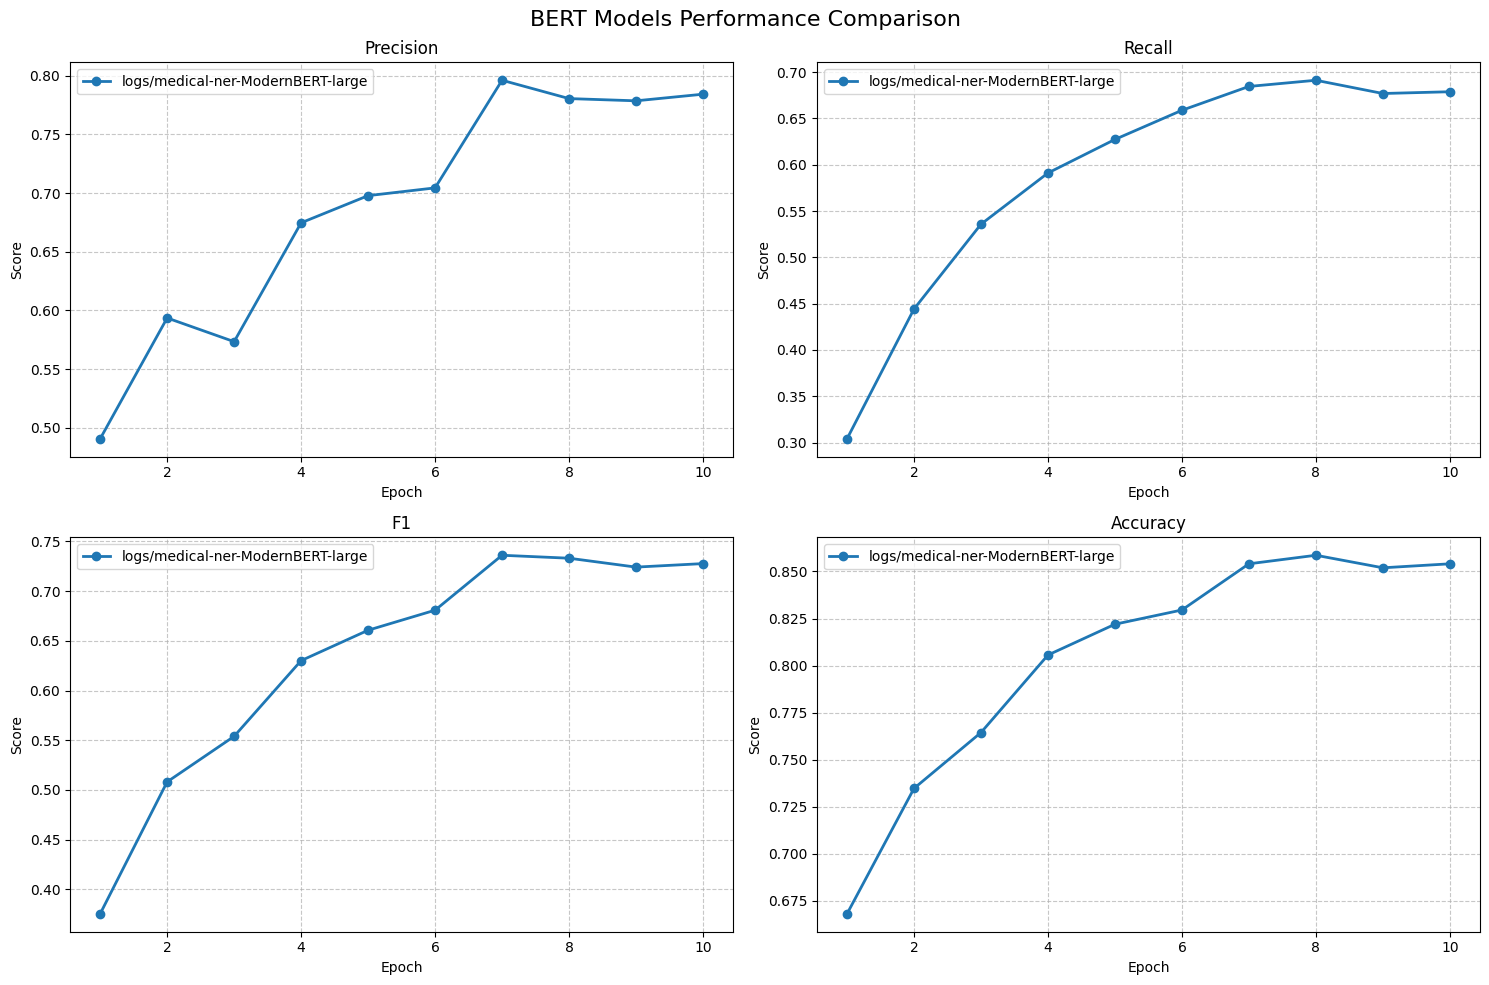


Final Metrics Comparison:
                               model  eval_precision  eval_recall   eval_f1  \
9  logs/medical-ner-ModernBERT-large        0.784141     0.678742  0.727644   

   eval_accuracy  
9       0.854072  


In [79]:
# Load all CSV files into a single dataframe with model name column
def load_results(file_paths):
    all_data = []
    for file_path in file_paths:
        df = pd.read_csv(file_path)
        model_name = file_path.replace('electrical-ner-', '').replace('-results.csv', '')
        df['model'] = model_name
        all_data.append(df)
    return pd.concat(all_data)

# Create comparison plots
df = load_results(files)

# Set style
# plt.style.use('seaborn')
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('BERT Models Performance Comparison', fontsize=16)

metrics = ['eval_precision', 'eval_recall', 'eval_f1', 'eval_accuracy']
colors = sns.color_palette('husl', n_colors=len(files))

for idx, metric in enumerate(metrics):
    ax = axes[idx//2, idx%2]
    for model, group in df.groupby('model'):
        ax.plot(group['epoch'], group[metric], marker='o', label=model, linewidth=2)

    ax.set_title(metric.replace('eval_', '').title())
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Score')
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend()

plt.tight_layout()
plt.savefig('bert_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Print final epoch metrics for each model
final_metrics = df[df['epoch'] == df['epoch'].max()].sort_values('eval_f1', ascending=False)
print("\nFinal Metrics Comparison:")
print(final_metrics[['model', 'eval_precision', 'eval_recall', 'eval_f1', 'eval_accuracy']])


# Test

In [80]:
from transformers import BertTokenizerFast, DistilBertTokenizerFast
from transformers import pipeline

In [81]:
model_fine_tuned = AutoModelForTokenClassification.from_pretrained(OUTPUT_MODEL)
tokenizer = DistilBertTokenizerFast.from_pretrained(OUTPUT_MODEL)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'PreTrainedTokenizerFast'. 
The class this function is called from is 'DistilBertTokenizerFast'.


In [82]:
def clean_and_group_entities(ner_results, min_score=0.40):
    """
    Cleans and groups named entity recognition (NER) results based on a minimum score threshold.

    Args:
        ner_results (list of dict): A list of dictionaries containing NER results. Each dictionary should have the keys:
            - "word" (str): The recognized word or token.
            - "entity_group" (str): The entity group or label.
            - "start" (int): The start position of the entity in the text.
            - "end" (int): The end position of the entity in the text.
            - "score" (float): The confidence score of the entity recognition.
        min_score (float, optional): The minimum score threshold for considering an entity. Defaults to 0.40.

    Returns:
        list of dict: A list of grouped entities that meet the minimum score threshold. Each dictionary contains:
            - "entity_group" (str): The entity group or label.
            - "word" (str): The concatenated word or token.
            - "start" (int): The start position of the entity in the text.
            - "end" (int): The end position of the entity in the text.
            - "score" (float): The minimum confidence score of the grouped entity.
    """
    grouped_entities = []
    current_entity = None

    for result in ner_results:
        # Skip entities with score below threshold
        if result["score"] < min_score:
            if current_entity:
                # Add current entity if it meets threshold
                if current_entity["score"] >= min_score:
                    grouped_entities.append(current_entity)
                current_entity = None
            continue

        word = result["word"].replace("##", "")  # Remove subword token markers

        if current_entity and result["entity_group"] == current_entity["entity_group"] and result["start"] == current_entity["end"]:
            # Continue the current entity
            current_entity["word"] += word
            current_entity["end"] = result["end"]
            current_entity["score"] = min(current_entity["score"], result["score"])

            # If combined score drops below threshold, discard the entity
            if current_entity["score"] < min_score:
                current_entity = None
        else:
            # Finalize the current entity if it meets threshold
            if current_entity and current_entity["score"] >= min_score:
                grouped_entities.append(current_entity)

            # Start a new entity
            current_entity = {
                "entity_group": result["entity_group"],
                "word": word,
                "start": result["start"],
                "end": result["end"],
                "score": result["score"]
            }

    # Add the last entity if it meets threshold
    if current_entity and current_entity["score"] >= min_score:
        grouped_entities.append(current_entity)

    return grouped_entities

In [91]:
pipe = pipeline("ner", model=model_fine_tuned, tokenizer=tokenizer, aggregation_strategy="simple")

example = """blood tests need"""

ner_results = pipe(example)

print(ner_results)

Device set to use cuda:0


[{'entity_group': 'TEST', 'score': 0.6097537, 'word': ' tests', 'start': 5, 'end': 11}]


In [92]:
# Clean and group entities
cleaned_results = clean_and_group_entities(ner_results)

# Convert to DataFrame for better visualization
df = pd.DataFrame(cleaned_results)
df

,entity_group,word,start,end,score
0,TEST,tests,5,11,0.609754
